<a href="https://colab.research.google.com/github/Ak-arsha/Traditional-Watermarking-via-SVD/blob/main/Traditional_Watermarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet opencv-python-headless pillow pywavelets scikit-image matplotlib numpy

In [ ]:
pip list

Package                                  Version
---------------------------------------- --------------------
absl-py                                  1.4.0
absolufy-imports                         0.3.1
accelerate                               1.11.0
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.1
aiosignal                                1.4.0
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.17.0
altair                                   5.5.0
annotated-doc                            0.0.3
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                                    4.11.0
anywidget                                0.9.18
argon2-cffi                        

In [ ]:
import cv2, numpy as np, matplotlib.pyplot as plt
from PIL import Image
import pywt
from skimage.metrics import peak_signal_noise_ratio as sk_psnr
from skimage.metrics import structural_similarity as sk_ssim
import random

# Reproducibility
np.random.seed(42)
random.seed(42)

def imread_rgb(path, size=None):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[:,:,::-1]  # BGR->RGB
    if size is not None:
        img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return img

def imwrite_rgb(path, img):
    cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

def show_images(grid, titles=None, figsize=(12,6)):
    n = len(grid)
    cols = min(3,n)
    rows = (n+cols-1)//cols
    plt.figure(figsize=figsize)
    for i,img in enumerate(grid):
        plt.subplot(rows,cols,i+1)
        plt.imshow(img.astype(np.uint8))
        plt.axis('off')
        if titles: plt.title(titles[i])
    plt.show()


**Taking Data Set from Kaggle**


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akarshaagarwal","key":"c1ac1624c2047306782749c2926506c0"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install --quiet kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k -p /content/retina --unzip

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other
 97% 1.58G/1.62G [00:16<00:00, 154MB/s]
100% 1.62G/1.62G [00:16<00:00, 107MB/s]


In [ ]:
import glob
import random

# Load random 5 images from ODIR-5K
image_paths = glob.glob("/content/retina/ODIR-5K/ODIR-5K/Training Images/*.jpg")
print("Total retina images found:", len(image_paths))

sample_paths = random.sample(image_paths, 5)
sample_paths

Total retina images found: 7000


['/content/retina/ODIR-5K/ODIR-5K/Training Images/30_left.jpg',
 '/content/retina/ODIR-5K/ODIR-5K/Training Images/1674_left.jpg',
 '/content/retina/ODIR-5K/ODIR-5K/Training Images/1554_left.jpg',
 '/content/retina/ODIR-5K/ODIR-5K/Training Images/2738_left.jpg',
 '/content/retina/ODIR-5K/ODIR-5K/Training Images/4635_left.jpg']

In [ ]:
!kaggle datasets list -s retina


ref                                                             title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
abdallahwagih/retina-blood-vessel                               Retina Blood Vessel                                    34470612  2023-08-17 13:35:15.923000           6043        118  0.75             
andrewmvd/retinal-disease-classification                        Retinal Disease Classification                       7973757355  2021-08-16 10:23:33.073000          19983        212  0.875            
paultimothymooney/kermany2018                                   Retinal OCT Images (optical coherence tomography)   11644282751  2018-03-25 15:04:56.410000          41123        580  0.75         

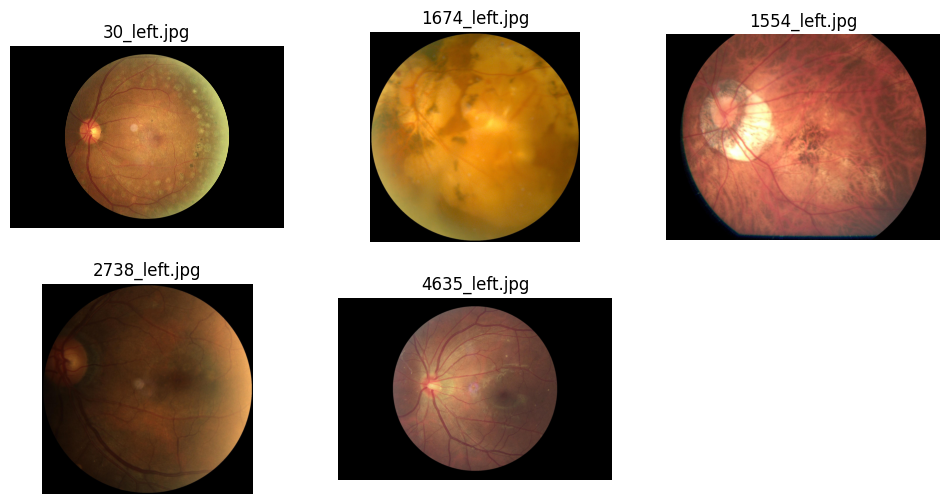

In [ ]:
sample_images = [imread_rgb(path) for path in sample_paths]
show_images(sample_images, titles=[path.split('/')[-1] for path in sample_paths])

In [ ]:
!ls "/content/retina/ODIR-5K/"

ODIR-5K


In [ ]:
!ls "/content/retina/ODIR-5K/Training Images/"

ls: cannot access '/content/retina/ODIR-5K/Training Images/': No such file or directory


In [ ]:
# Placeholder: Define a dummy watermark image for demonstration
watermark = np.zeros((100, 100, 3), dtype=np.uint8) # Create a black 100x100 RGB image

wm_gray = cv2.cvtColor(watermark, cv2.COLOR_RGB2GRAY)
wm_gray = cv2.resize(wm_gray, (64, 64))

In [ ]:
import glob
import random

image_paths = glob.glob("/content/retina/ODIR-5K/ODIR-5K/Training Images/*.jpg")
print("Total retina images found:", len(image_paths))
sample_paths = image_paths[:5]

Total retina images found: 7000


In [ ]:
import numpy as np
import cv2

def embed_svd(host_rgb, wm_gray, alpha=0.5):
    # Convert host image to grayscale
    host = cv2.cvtColor(host_rgb, cv2.COLOR_RGB2GRAY)
    # Get dimensions of the host image
    m, n = host.shape
    # Perform SVD
    U, S, V = np.linalg.svd(host, full_matrices=True)

    # Resize watermark to match the number of singular values and ensure it's a 1D array
    wm_gray_resized = cv2.resize(wm_gray, (min(m, n), 1)).flatten()
    wm_vec = wm_gray_resized

    if wm_vec.ndim != 1 or len(wm_vec) != min(m, n):
        raise ValueError("Resized watermark vector does not match length of singular values.")

    # Explicitly cast S to float before addition
    S = S.astype(np.float64)
    S[:len(wm_vec)] = S[:len(wm_vec)] + alpha * wm_vec

    # Construct a rectangular diagonal matrix for S
    S_diag = np.zeros((m, n), dtype=np.float64)
    np.fill_diagonal(S_diag, S[:min(m, n)])

    # Reconstruct the watermarked image
    wm_host_gray = U @ S_diag @ V
    wm_host_gray = np.clip(wm_host_gray, 0, 255).astype(np.uint8)
    wm_host_rgb = cv2.cvtColor(wm_host_gray, cv2.COLOR_GRAY2RGB)
    return wm_host_rgb, (U, V, S)

def jpeg_compress(img_rgb, quality=30):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    result, encimg = cv2.imencode('.jpg', cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR), encode_param)
    decimg = cv2.imdecode(encimg, 1)
    return cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)

def extract_svd(wm_host_rgb, svd_meta, alpha=0.5, k=64*64):
    wm_host_gray = cv2.cvtColor(wm_host_rgb, cv2.COLOR_RGB2GRAY)
    U_orig, V_orig, S_orig = svd_meta
    U_wm, S_wm, V_wm = np.linalg.svd(wm_host_gray)
    # Ensure k is not larger than the number of singular values in the extracted SVD
    k_eff = min(k, len(S_wm))
    est_S = (S_wm[:k_eff] - S_orig[:k_eff]) / alpha
    est_vec = est_S.flatten()
    # Threshold the extracted vector and resize it to the original watermark size (64x64)
    est_bin_thresholded = (est_vec > np.mean(est_vec)).astype(np.uint8) * 255 # Scale to 0 or 255
    # Reshape the 1D thresholded array into a 2D array (e.g., a column vector) before resizing
    est_bin_2d = est_bin_thresholded.reshape(-1, 1)
    est_bin = cv2.resize(est_bin_2d, (int(np.sqrt(k)), int(np.sqrt(k)))) # Resize to 64x64
    return est_vec, est_bin

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as sk_psnr
from skimage.metrics import structural_similarity as sk_ssim

def compute_psnr(img1, img2):
    return sk_psnr(img1, img2)

def compute_ssim(img1, img2):
    return sk_ssim(img1, img2, channel_axis=-1)

Lossy Compression


Dataset 1 - JPEG Compression: PSNR=16.63, SSIM=0.75
Dataset 1 - Gaussian Noise: PSNR=16.64, SSIM=0.72
Dataset 1 - Blurring: PSNR=16.64, SSIM=0.78
Dataset 1 - Rotation: PSNR=16.44, SSIM=0.63
Dataset 1 - Cropping: PSNR=14.98, SSIM=0.49
Dataset 2 - JPEG Compression: PSNR=20.67, SSIM=0.95
Dataset 2 - Gaussian Noise: PSNR=20.66, SSIM=0.82
Dataset 2 - Blurring: PSNR=20.67, SSIM=0.97
Dataset 2 - Rotation: PSNR=20.39, SSIM=0.91
Dataset 2 - Cropping: PSNR=14.47, SSIM=0.80
Dataset 3 - JPEG Compression: PSNR=19.14, SSIM=0.89
Dataset 3 - Gaussian Noise: PSNR=19.11, SSIM=0.75
Dataset 3 - Blurring: PSNR=19.15, SSIM=0.90
Dataset 3 - Rotation: PSNR=18.91, SSIM=0.85
Dataset 3 - Cropping: PSNR=17.49, SSIM=0.74
Dataset 4 - JPEG Compression: PSNR=14.04, SSIM=0.83
Dataset 4 - Gaussian Noise: PSNR=14.04, SSIM=0.73
Dataset 4 - Blurring: PSNR=14.04, SSIM=0.86
Dataset 4 - Rotation: PSNR=13.83, SSIM=0.78
Dataset 4 - Cropping: PSNR=12.01, SSIM=0.67
Dataset 5 - JPEG Compression: PSNR=19.13, SSIM=0.93
Dataset 5 - 

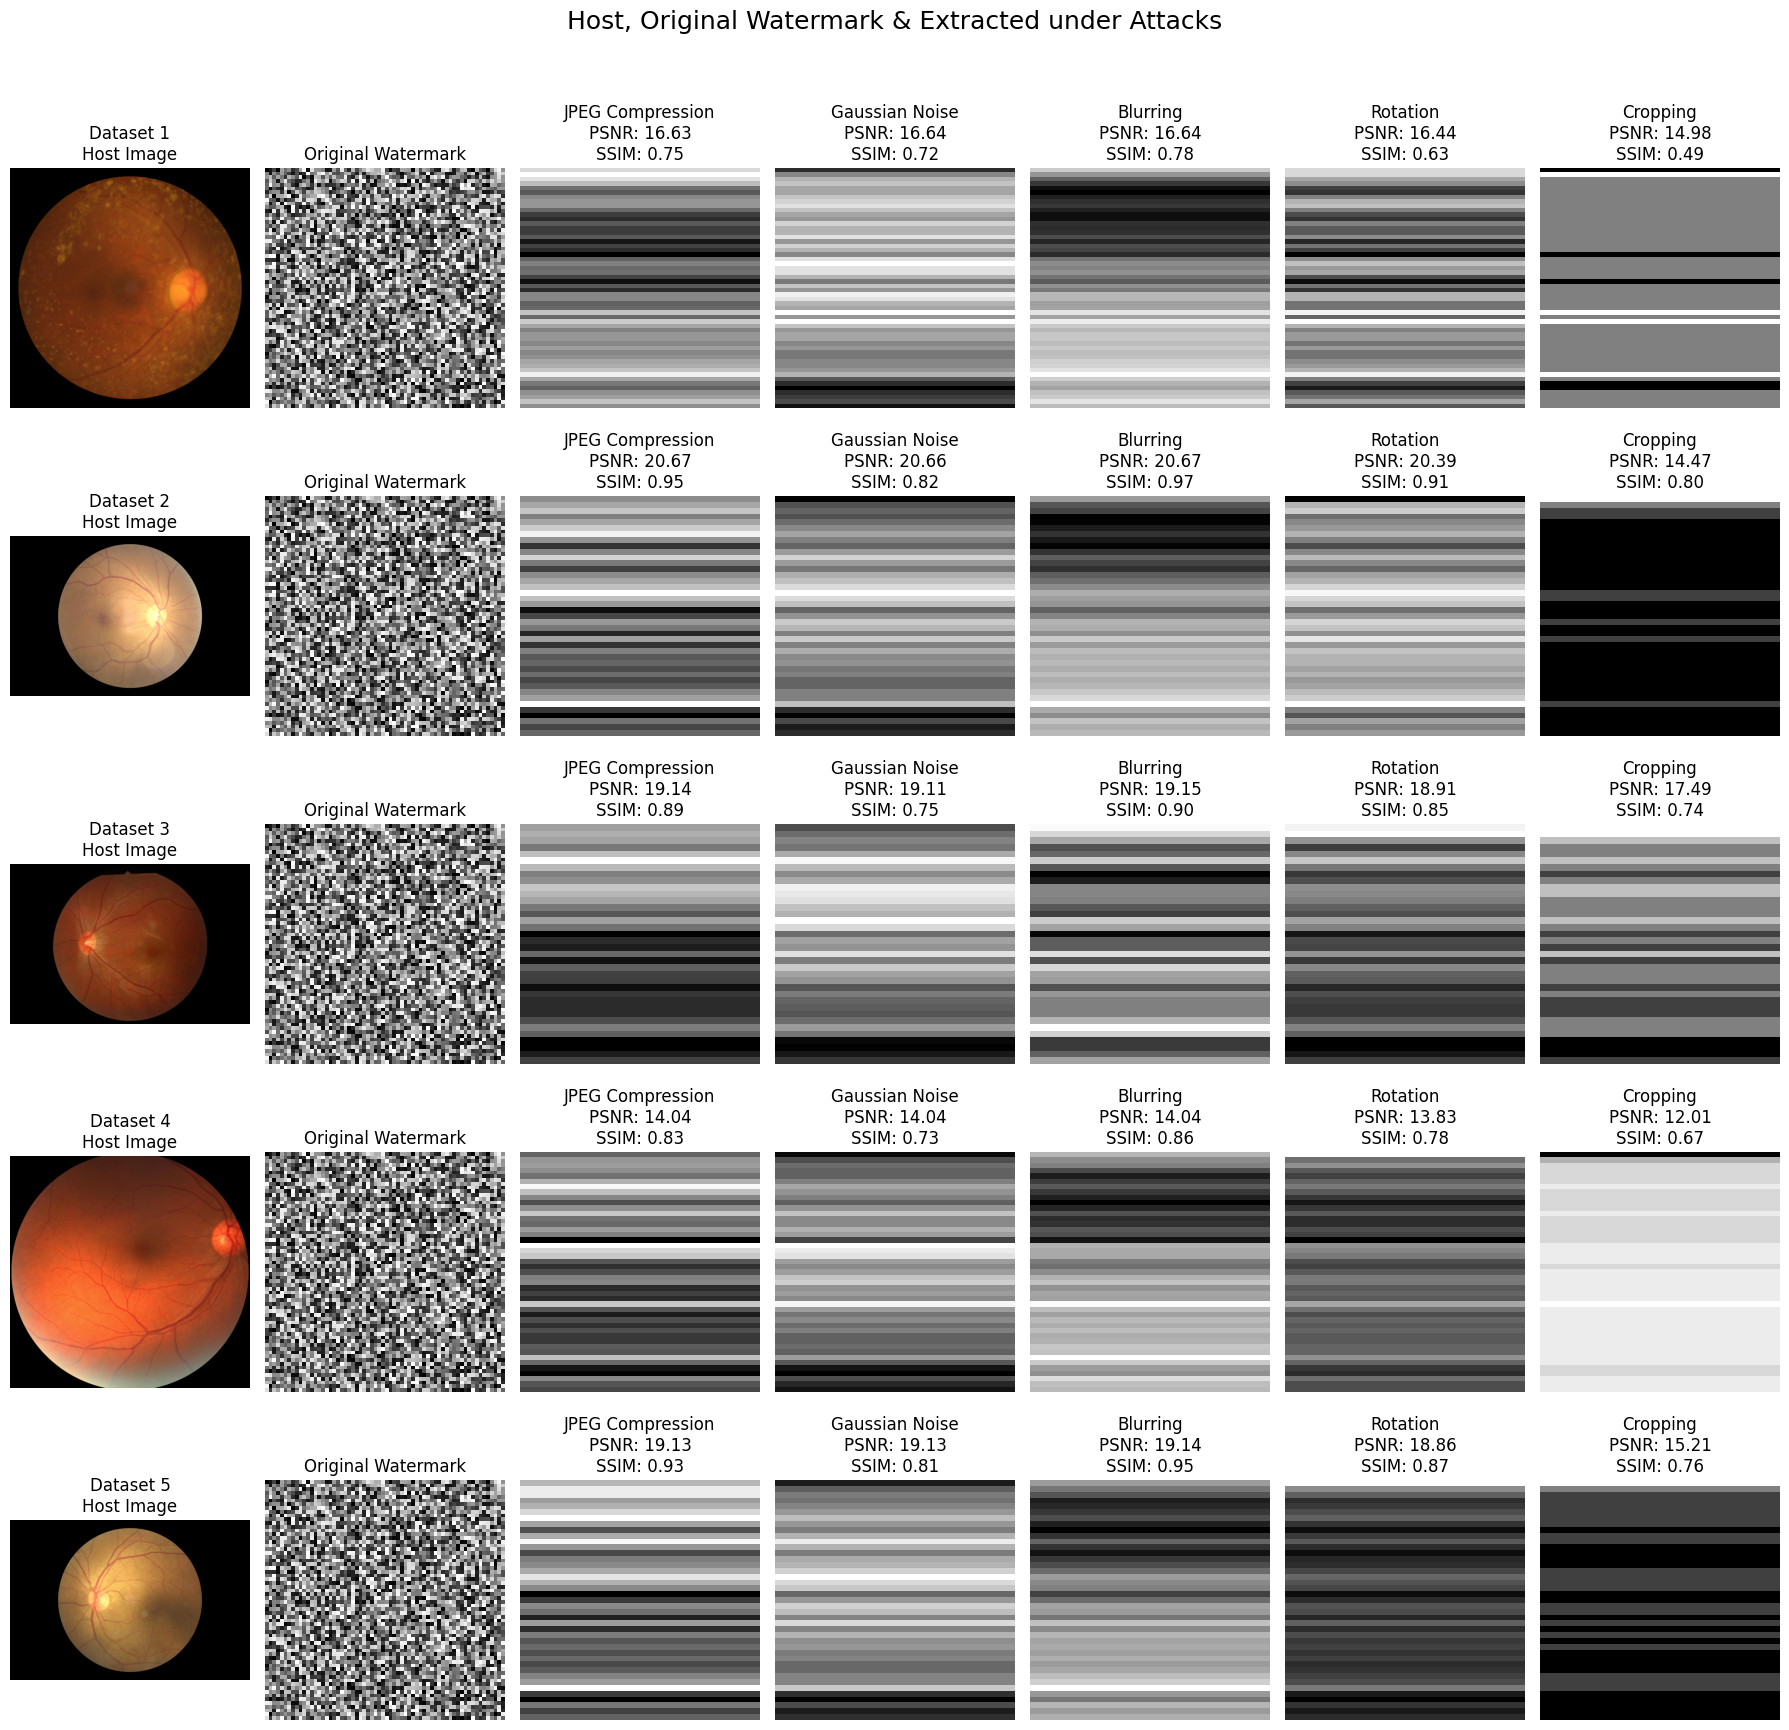

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as sk_psnr
from skimage.metrics import structural_similarity as sk_ssim
import os

# === Utility Functions ===

def imread_rgb(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Could not load image at {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def compute_psnr(img1, img2):
    return sk_psnr(img1, img2)

def compute_ssim(img1, img2):
    return sk_ssim(img1, img2, channel_axis=-1)

# === SVD Watermark Embed/Extract ===

def embed_svd(host_rgb, wm_gray, alpha=0.5):
    host = cv2.cvtColor(host_rgb, cv2.COLOR_RGB2GRAY)
    m, n = host.shape
    U, S, V = np.linalg.svd(host, full_matrices=True)

    wm_gray_resized = cv2.resize(wm_gray, (min(m, n), 1)).flatten()

    S = S.astype(np.float64)
    S[:len(wm_gray_resized)] += alpha * wm_gray_resized

    S_diag = np.zeros((m, n), dtype=np.float64)
    np.fill_diagonal(S_diag, S[:min(m, n)])

    wm_host_gray = U @ S_diag @ V
    wm_host_gray = np.clip(wm_host_gray, 0, 255).astype(np.uint8)
    wm_host_rgb = cv2.cvtColor(wm_host_gray, cv2.COLOR_GRAY2RGB)
    return wm_host_rgb, (U, V, S)

def extract_svd(wm_host_rgb, svd_meta, alpha=0.5, k=64*64):
    wm_host_gray = cv2.cvtColor(wm_host_rgb, cv2.COLOR_RGB2GRAY)
    U_orig, V_orig, S_orig = svd_meta
    U_wm, S_wm, V_wm = np.linalg.svd(wm_host_gray)
    k_eff = min(k, len(S_wm))
    est_S = (S_wm[:k_eff] - S_orig[:k_eff]) / alpha
    est_vec = est_S.flatten()
    est_norm = cv2.normalize(est_vec, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    side = int(np.sqrt(k_eff))
    est_bin = cv2.resize(est_norm.reshape(-1, 1), (side, side))
    return est_vec, est_bin

# === Attack Functions ===

def jpeg_compress(img_rgb, quality=30):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    result, encimg = cv2.imencode('.jpg', cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR), encode_param)
    decimg = cv2.imdecode(encimg, 1)
    return cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)

def add_gaussian_noise(img_rgb, mean=0, var=10):
    noise = np.random.normal(mean, np.sqrt(var), img_rgb.shape)
    noisy = img_rgb + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

def blur_image(img_rgb, ksize=5):
    return cv2.GaussianBlur(img_rgb, (ksize, ksize), 0)

def rotate_image(img_rgb, angle=10):
    h, w = img_rgb.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    return cv2.warpAffine(img_rgb, M, (w, h))

def crop_image(img_rgb, crop_ratio=0.9):
    h, w = img_rgb.shape[:2]
    ch, cw = int(h * crop_ratio), int(w * crop_ratio)
    cropped = img_rgb[h//2 - ch//2:h//2 + ch//2, w//2 - cw//2:w//2 + cw//2]
    return cv2.resize(cropped, (w, h))

# === Processing & Visualization ===

def process_and_visualize(sample_paths, wm_gray):
    attacks = {
        "JPEG Compression": lambda img: jpeg_compress(img, quality=30),
        "Gaussian Noise": add_gaussian_noise,
        "Blurring": blur_image,
        "Rotation": rotate_image,
        "Cropping": crop_image
    }

    fig, axes = plt.subplots(len(sample_paths), len(attacks) + 2, figsize=(18, 18))
    fig.suptitle("Host, Original Watermark & Extracted under Attacks", fontsize=18)

    for i, path in enumerate(sample_paths):
        host = imread_rgb(path)
        wm_host_rgb, svd_meta = embed_svd(host, wm_gray)

        # Column 0: Host image
        axes[i, 0].imshow(host)
        axes[i, 0].set_title(f"Dataset {i+1}\nHost Image")
        axes[i, 0].axis("off")

        # Column 1: Original Watermark
        axes[i, 1].imshow(wm_gray, cmap='gray')
        axes[i, 1].set_title("Original Watermark")
        axes[i, 1].axis("off")

        # Apply each attack
        for j, (atk_name, atk_func) in enumerate(attacks.items(), start=2):
            attacked = atk_func(wm_host_rgb)
            est_vec, est_bin = extract_svd(attacked, svd_meta)

            psnr_value = compute_psnr(host, attacked)
            ssim_value = compute_ssim(host, attacked)

            axes[i, j].imshow(est_bin, cmap='gray')
            axes[i, j].set_title(f"{atk_name}\nPSNR: {psnr_value:.2f}\nSSIM: {ssim_value:.2f}")
            axes[i, j].axis("off")

            print(f"Dataset {i+1} - {atk_name}: PSNR={psnr_value:.2f}, SSIM={ssim_value:.2f}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Example usage
# Your provided sample_paths and wm_gray
sample_paths = [
    '/content/retina/ODIR-5K/ODIR-5K/Training Images/511_right.jpg',
    '/content/retina/ODIR-5K/ODIR-5K/Training Images/681_right.jpg',
    '/content/retina/ODIR-5K/ODIR-5K/Training Images/4219_left.jpg',
    '/content/retina/ODIR-5K/ODIR-5K/Training Images/2519_right.jpg',
    '/content/retina/ODIR-5K/ODIR-5K/Training Images/4258_left.jpg'
]

wm_gray = (np.random.rand(64, 64) * 255).astype(np.uint8)


process_and_visualize(sample_paths, wm_gray)

Dataset 1 - JPEG Compression: PSNR=16.62, SSIM=0.75
Dataset 1 - Gaussian Noise: PSNR=16.64, SSIM=0.71
Dataset 1 - Blurring: PSNR=16.64, SSIM=0.79
Dataset 1 - Rotation: PSNR=16.43, SSIM=0.62
Dataset 1 - Cropping: PSNR=14.98, SSIM=0.48
Dataset 2 - JPEG Compression: PSNR=20.65, SSIM=0.94
Dataset 2 - Gaussian Noise: PSNR=20.65, SSIM=0.81
Dataset 2 - Blurring: PSNR=20.67, SSIM=0.97
Dataset 2 - Rotation: PSNR=20.38, SSIM=0.90
Dataset 2 - Cropping: PSNR=14.46, SSIM=0.79
Dataset 3 - JPEG Compression: PSNR=19.13, SSIM=0.88
Dataset 3 - Gaussian Noise: PSNR=19.10, SSIM=0.74
Dataset 3 - Blurring: PSNR=19.15, SSIM=0.90
Dataset 3 - Rotation: PSNR=18.90, SSIM=0.84
Dataset 3 - Cropping: PSNR=17.48, SSIM=0.73
Dataset 4 - JPEG Compression: PSNR=14.04, SSIM=0.82
Dataset 4 - Gaussian Noise: PSNR=14.03, SSIM=0.72
Dataset 4 - Blurring: PSNR=14.04, SSIM=0.86
Dataset 4 - Rotation: PSNR=13.83, SSIM=0.77
Dataset 4 - Cropping: PSNR=12.00, SSIM=0.66
Dataset 5 - JPEG Compression: PSNR=19.12, SSIM=0.92
Dataset 5 - 

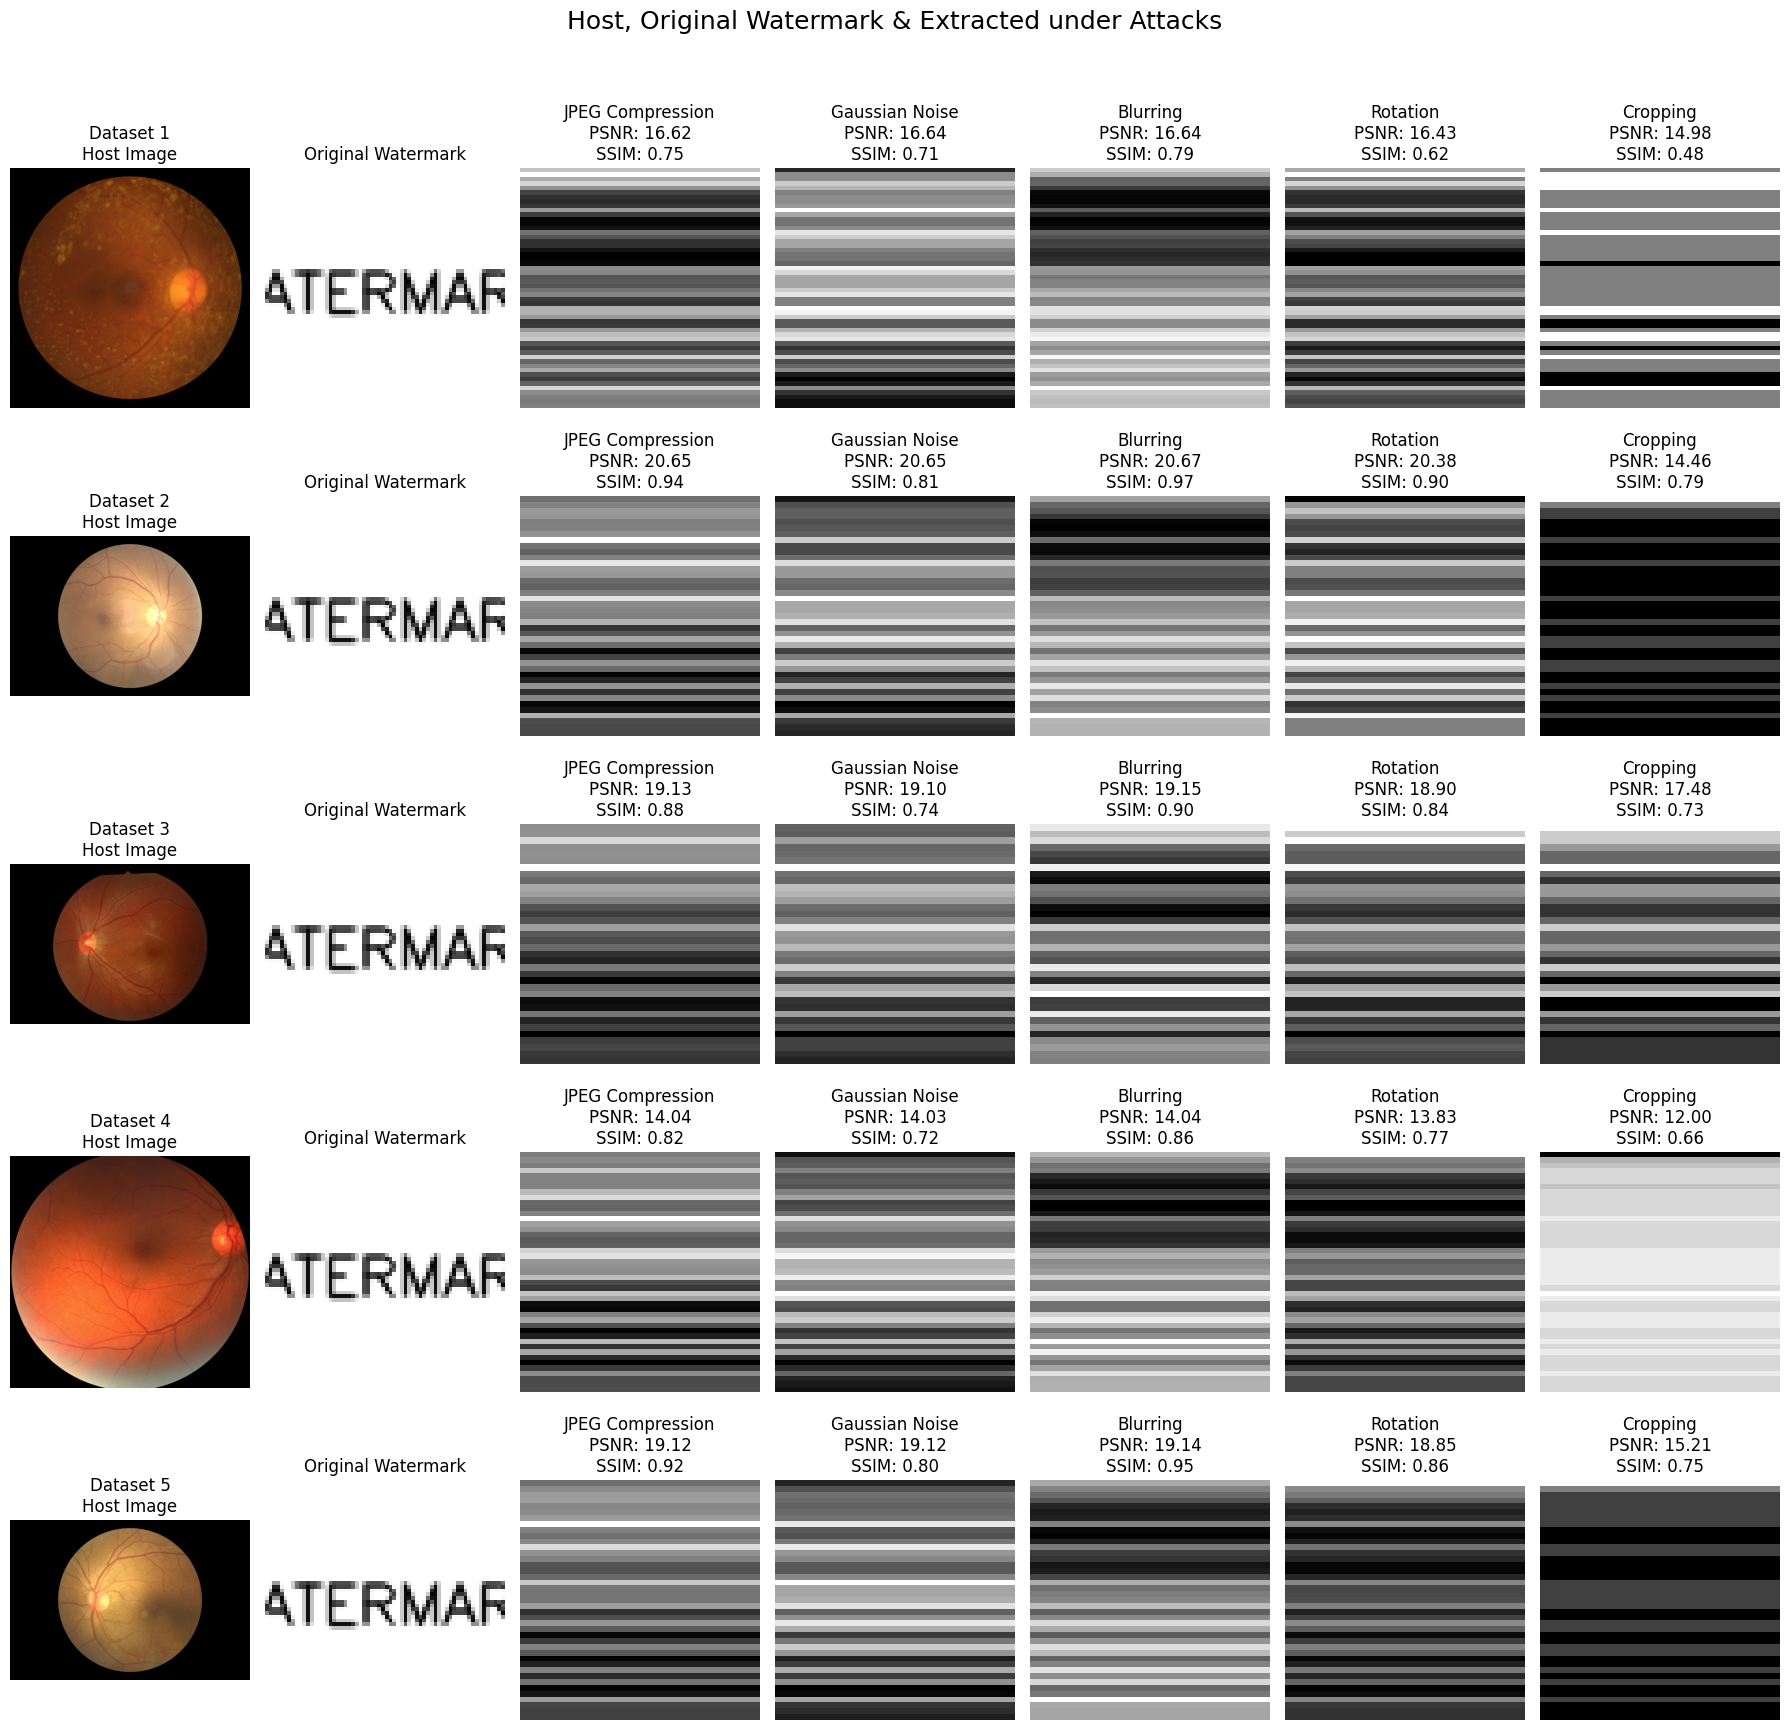

In [ ]:
wm_text = "WATERMARK"
wm_width = 64
wm_height = 64

# Create a blank white image
wm_img = 255 * np.ones((wm_height, wm_width), dtype=np.uint8)

# Add text to the watermark image
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
thickness = 1
text_size, _ = cv2.getTextSize(wm_text, font, font_scale, thickness)
text_x = (wm_width - text_size[0]) // 2
text_y = (wm_height + text_size[1]) // 2
cv2.putText(wm_img, wm_text, (text_x, text_y), font, font_scale, (0), thickness, cv2.LINE_AA)

wm_gray = wm_img

process_and_visualize(sample_paths, wm_gray)

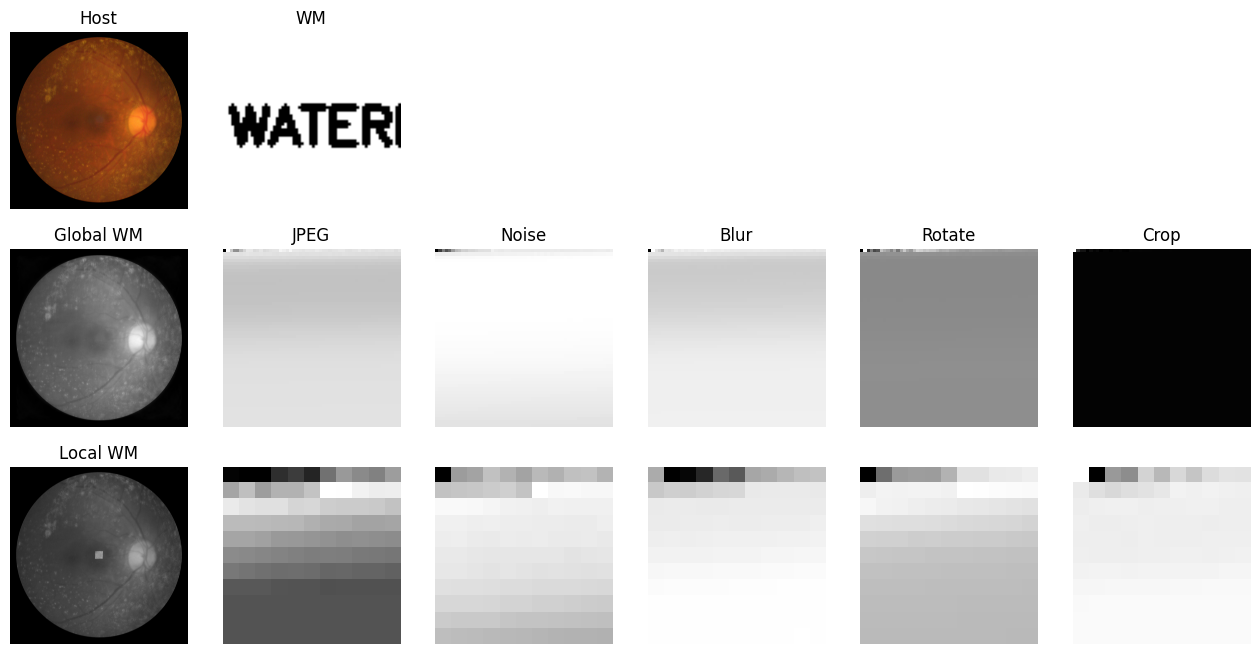

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

def imread_rgb(p): return cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)

# -------- SVD Block Embed --------
def svd_embed_block(host, wm, alpha=0.2):
    h, w = host.shape
    wm = cv2.resize(wm, (w, h))

    U, S, V = np.linalg.svd(host.astype(np.float32), full_matrices=True)
    WU, WS, WV = np.linalg.svd(wm.astype(np.float32), full_matrices=True)

    S_mod = S + alpha * WS  # embed watermark S

    S_mat = np.zeros_like(host, dtype=np.float32)
    np.fill_diagonal(S_mat, S_mod[:min(h,w)])

    wm_host = U @ S_mat @ V
    wm_host = np.clip(wm_host, 0, 255).astype(np.uint8)

    return wm_host, (U, S_mod, V)

# -------- Extraction --------
def svd_extract_block(attacked, meta, alpha=0.2):
    U0, S_embed, V0 = meta
    Ua, Sa, Va = np.linalg.svd(attacked.astype(np.float32))

    Wrec = (Sa - S_embed) / alpha
    size = int(np.sqrt(len(Wrec)))
    Wrec = Wrec[:size*size].reshape(size,size)
    return cv2.normalize(Wrec, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# ---- Local Embed In Center ----
def embed_local(host, wm, alpha=0.35):
    host_g = cv2.cvtColor(host, cv2.COLOR_RGB2GRAY)
    h,w = host_g.shape
    bh,bw = 128,128; y,x = h//2-bh//2, w//2-bw//2

    block = host_g[y:y+bh, x:x+bw]
    wm_small = cv2.resize(wm,(bw,bh))
    wm_block, meta = svd_embed_block(block, wm_small, alpha)

    host_mod = host_g.copy()
    host_mod[y:y+bh, x:x+bw] = wm_block
    return cv2.cvtColor(host_mod, cv2.COLOR_GRAY2RGB), (meta,(x,y,bw,bh))

def extract_local(att, meta, alpha=0.35):
    (m,(x,y,bw,bh)) = meta
    block = cv2.cvtColor(att, cv2.COLOR_RGB2GRAY)[y:y+bh, x:x+bw]
    return svd_extract_block(block, m, alpha)

# ---- Attacks ----
def jpeg(img): enc=cv2.imencode(".jpg",cv2.cvtColor(img,cv2.COLOR_RGB2BGR),[1,20])[1]; return cv2.cvtColor(cv2.imdecode(enc,1),cv2.COLOR_BGR2RGB)
def noise(img): return np.clip(img+np.random.normal(0,10,img.shape),0,255).astype(np.uint8)
def blur(img): return cv2.GaussianBlur(img,(5,5),0)
def rot(img):
    h,w=img.shape[:2]; M=cv2.getRotationMatrix2D((w//2,h//2),10,1)
    return cv2.warpAffine(img,M,(w,h))
def crop(img):
    h,w=img.shape[:2]; ch,cw=int(0.9*h),int(0.9*w)
    c=img[h//2-ch//2:h//2+ch//2, w//2-cw//2:w//2+cw//2]
    return cv2.resize(c,(w,h))

attacks={"JPEG":jpeg,"Noise":noise,"Blur":blur,"Rotate":rot,"Crop":crop}

# Test Path
img=imread_rgb('/content/retina/ODIR-5K/ODIR-5K/Training Images/511_right.jpg')
wm = np.ones((64,64))*255
cv2.putText(wm,"WATERMARK",(2,40),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0),2)

g_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
g_mark, g_meta = svd_embed_block(g_gray, wm, 0.12)
g_mark_rgb = cv2.cvtColor(g_mark, cv2.COLOR_GRAY2RGB)

l_mark_rgb, l_meta = embed_local(img, wm)

fig,ax=plt.subplots(3,6,figsize=(16,8))
ax[0,0].imshow(img); ax[0,0].set_title("Host")
ax[0,1].imshow(wm,cmap='gray'); ax[0,1].set_title("WM")
ax[1,0].imshow(g_mark_rgb); ax[1,0].set_title("Global WM")
ax[2,0].imshow(l_mark_rgb); ax[2,0].set_title("Local WM")

for i,(atk,fun) in enumerate(attacks.items()):
    g_at = fun(g_mark_rgb)
    l_at = fun(l_mark_rgb)

    g_ext = svd_extract_block(cv2.cvtColor(g_at,cv2.COLOR_RGB2GRAY), g_meta)
    l_ext = extract_local(l_at, l_meta)

    ax[1,i+1].imshow(g_ext,cmap='gray'); ax[1,i+1].set_title(atk)
    ax[2,i+1].imshow(l_ext,cmap='gray')

for r in ax: [a.axis('off') for a in r]
plt.show()
